# Inventory Management

## High Demand Products


In inventory management, it is essential to prioritize products based on demand to optimize stock levels and reduce costs. High-demand products, which drive a significant portion of sales, require frequent monitoring to ensure stock availability and avoid costly stockouts. In contrast, low- and medium-demand products can be managed with less frequent checks. Our code focuses specifically on high-demand products to maintain efficient inventory turnover and prevent disruptions in supply for these key items, as managing them closely has the greatest impact on overall business performance.

## Inventory Turnover Ratio
The inventory turnover ratio is a key metric that shows how efficiently a company manages its inventory. It measures how many times, on average, inventory is sold and replaced over a specific period (usually one year). A higher turnover ratio generally indicates effective inventory management, meaning the company is selling goods quickly and not overstocking. Conversely, a lower turnover ratio can suggest excess inventory, which ties up cash and increases holding costs.



The inventory turnover ratio is calculated as:

<div align="center">

$$
\text{Inventory Turnover Ratio} = \frac{\text{Total Demand}}{\text{Average Inventory Level}}
$$

</div>


​
 
- Total Demand represents the total amount of inventory sold during the period.
- Average Inventory Level is typically calculated as the average of the inventory at the beginning and end of the period.


## Current Turnover Ratio

Let's calculate the current turnover ratio of products with high demand.

In [1]:
import pandas as pd
import requests
from io import StringIO
import certifi
import matplotlib.pyplot as plt
from prophet import Prophet
import numpy as np

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


We categorise our products into 3 groups: A, B and C.

- A-items: High demand products, top 20% of products that contribute the most to total demand.
- B-items: Medium-demand products, accounting for the next 30%.
- C-items: Low-demand products, comprising the remaining 50%.

We will focus on the A-items

In [2]:
# Define the Google Drive link and convert it to a direct download link
csv_url = 'https://drive.google.com/file/d/1GB-if5xcQM64dV4O6_H-HjcgOK21Z9j2/view?usp=sharing'
file_id = csv_url.split('/')[-2]
dwn_url = f'https://drive.google.com/uc?id={file_id}'

# Get the CSV data with SSL verification
response = requests.get(dwn_url, verify=certifi.where()).text

# Load the CSV content directly into a pandas DataFrame without saving it
csv_raw = StringIO(response)
data = pd.read_csv(csv_raw)
data['Invoice Date'] = pd.to_datetime(data['Invoice Date'])

# Calculate total demand (quantity sold) and total sales value for each StockCode
product_demand = data.groupby('StockCode').agg({
    'Quantity': 'sum',  # Total quantity sold
    'TotalPrice': 'sum'  # Total revenue
}).reset_index()

# Rank products by total demand in descending order for ABC analysis
product_demand = product_demand.sort_values(by='Quantity', ascending=False)
product_demand['Cumulative_Demand'] = product_demand['Quantity'].cumsum()
total_demand = product_demand['Quantity'].sum()

# Rename 'Quantity' to 'TotalDemand' for clarity
product_demand.rename(columns={'Quantity': 'TotalDemand'}, inplace=True)


# Classify products based on cumulative demand percentages
product_demand['Demand_Percentage'] = product_demand['Cumulative_Demand'] / total_demand
product_demand['ABC_Category'] = pd.cut(
    product_demand['Demand_Percentage'],
    bins=[0, 0.2, 0.5, 1.0],  # Top 20%, next 30%, and remaining 50%
    labels=['A', 'B', 'C']
)

product_demand.head()


,StockCode,TotalDemand,TotalPrice,Cumulative_Demand,Demand_Percentage,ABC_Category
1115,22197,56427,50967.92,56427,0.010512,A
2927,84077,53751,13560.09,110178,0.020525,A
3418,85099B,47260,92175.79,157438,0.029329,A
3438,85123A,39067,97838.45,196505,0.036607,A
3216,84879,36282,58792.42,232787,0.043366,A


### Generate Synthetic Data to estimate the current inventory levels of the products

In [3]:
# Set a random seed for reproducibility
np.random.seed(42)

a_items_data = product_demand[product_demand['ABC_Category'] == 'A'][['StockCode', 'TotalPrice', 'TotalDemand']]

# scale_factor = 1.1 for high demand products to reduce the risk of stockouts
# Assuming 'EstimatedInventory' based on TotalDemand with a scale factor
def generate_inventory_levels(product_data, scale_factor=1.1, base_stock=10):
    # Calculate estimated inventory levels based on TotalDemand
    product_data['EstimatedInventory'] = (product_data['TotalDemand'] * scale_factor 
                                          + np.random.normal(loc=base_stock, scale=5, size=len(product_data)))

    # Round and ensure no negative inventory levels
    product_data['EstimatedInventory'] = product_data['EstimatedInventory'].round().astype(int)
    product_data['EstimatedInventory'] = product_data['EstimatedInventory'].clip(lower=0)
    return product_data[['StockCode', 'TotalDemand', 'TotalPrice', 'EstimatedInventory']]



# Generate synthetic inventory levels with TotalDemand included
synthetic_data = generate_inventory_levels(a_items_data)

synthetic_data.head()


,StockCode,TotalDemand,TotalPrice,EstimatedInventory
1115,22197,56427,50967.92,62082
2927,84077,53751,13560.09,59135
3418,85099B,47260,92175.79,51999
3438,85123A,39067,97838.45,42991
3216,84879,36282,58792.42,39919


In [4]:
# Calculate Inventory Turnover Ratio using TotalPrice (proxy for COGS)
synthetic_data['InventoryTurnoverRatio'] = synthetic_data['TotalPrice'] / synthetic_data['EstimatedInventory']

# Calculate the average inventory turnover ratio
average_turnover_ratio = synthetic_data['InventoryTurnoverRatio'].mean()

# Display the result
synthetic_data[['StockCode', 'TotalDemand', 'TotalPrice', 'EstimatedInventory', 'InventoryTurnoverRatio']]
average_turnover_ratio

/var/folders/hm/csp3y_7176zb7m0yky72dwfc0000gn/T/ipykernel_18503/4004396545.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  synthetic_data['InventoryTurnoverRatio'] = synthetic_data['TotalPrice'] / synthetic_data['EstimatedInventory']


1.4087278709796334


Currently, the UCI Online Retail set has an Average Inventory Turnover Ratio of 1.4087278709796334, which signals inefficiencies in inventory management. For e-commerce, a healthy turnover ratio typically falls within the range of 1.5 to 2.0, indicating that inventory cycles align more closely with actual demand. Raising the turnover ratio to this optimal range would reduce holding costs and free up cash that’s currently tied up in unsold stock, minimizing the risk of obsolescence. This can be done using our demand forecasting model and inventory optimisation algorithm.

## How can we optimize inventory levels to minimize costs while ensuring product availability?

In this section, we develop a demand forecasting model and an inventory optimization algorithm aimed at increasing the inventory turnover ratio. By forecasting demand more accurately, we can better align stock levels with actual sales, reducing excess inventory. The optimization algorithm calculates reorder points, safety stock, and economic order quantities (EOQ) to maintain lean inventory levels, minimize holding costs, and ensure products move quickly through the inventory cycle. Together, these methods are designed to improve inventory efficiency and boost turnover.

### Demand Forecasting Model

In [5]:
# Filter the dataset for A-items based on the ABC analysis
a_items = product_demand[product_demand['ABC_Category'] == 'A']['StockCode']

# Dictionary to store forecasts for each A-item
forecasts = {}

for stockcode in a_items:
    # Prepare the product-specific time series data
    product_data = data[data['StockCode'] == stockcode]
    product_data = product_data.groupby('Invoice Date')['Quantity'].sum().reset_index()
    product_data.columns = ['ds', 'y']
    
    # Initialize and fit Prophet model
    model = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)
    model.fit(product_data)
    
    # Create future dates for forecast (e.g., 52 weeks into the future)
    future_dates = model.make_future_dataframe(periods=52, freq='W')
    forecast = model.predict(future_dates)
    
    # Store the forecast in the dictionary for further analysis
    forecasts[stockcode] = forecast

# The `forecasts` dictionary now contains Prophet model results for each A-item


20:57:29 - cmdstanpy - INFO - Chain [1] start processing
20:57:29 - cmdstanpy - INFO - Chain [1] done processing
20:57:30 - cmdstanpy - INFO - Chain [1] start processing
20:57:30 - cmdstanpy - INFO - Chain [1] done processing
20:57:30 - cmdstanpy - INFO - Chain [1] start processing
20:57:30 - cmdstanpy - INFO - Chain [1] done processing
20:57:30 - cmdstanpy - INFO - Chain [1] start processing
20:57:30 - cmdstanpy - INFO - Chain [1] done processing
20:57:30 - cmdstanpy - INFO - Chain [1] start processing
20:57:30 - cmdstanpy - INFO - Chain [1] done processing
20:57:30 - cmdstanpy - INFO - Chain [1] start processing
20:57:30 - cmdstanpy - INFO - Chain [1] done processing
20:57:30 - cmdstanpy - INFO - Chain [1] start processing
20:57:30 - cmdstanpy - INFO - Chain [1] done processing
20:57:31 - cmdstanpy - INFO - Chain [1] start processing
20:57:31 - cmdstanpy - INFO - Chain [1] done processing
20:57:31 - cmdstanpy - INFO - Chain [1] start processing
20:57:31 - cmdstanpy - INFO - Chain [1]

### Inventory Optimisation Algorithm

#### 1) Economic Order Quantity (EOQ)

The EOQ is used to determine the optimal order size that minimizes total inventory costs, which include both ordering and holding costs. By ordering the ideal quantity, businesses can reduce the frequency of orders while avoiding excess stock.

The EOQ formula is given by:

$$
\text{EOQ} = \sqrt{\frac{2 \times D \times S}{H}}
$$

Where:

D = Total demand for the product (units per period)

S = Ordering cost per order

H = Holding cost per unit per period


#### 2) Safety Stock
Safety Stock is an additional quantity of inventory kept on hand to protect against uncertainties in demand and supply. It acts as a buffer to prevent stockouts during unexpected spikes in demand or delays in replenishment.

$$
\text{Safety Stock} = Z \times \sigma_d \times \sqrt{L}
$$

Where:

Z = Service level factor

**$ \sigma_d $**: The standard deviation of demand during lead time.

 L: The lead time, or the time it takes for an order to be received after it is placed.

#### 3) Reorder Point (ROP)

The ROP is the inventory level at which a new order should be placed to replenish stock before it runs out. This ensures that you have enough inventory on hand to cover demand during the lead time, factoring in safety stock as a buffer.

$$
\text{ROP} = \text{Lead Time Demand} + \text{Safety Stock}
$$

Where:

- Lead Time Demand: The expected demand during the lead time, calculated as the average demand per period multiplied by the lead time.
- Safety Stock: The additional inventory kept on hand to account for demand and supply variability.



In [6]:
# We assume that
ordering_cost_per_order = 50 # can range from tens to hundreds
holding_cost_per_unit_per_week = 0.5 # affordable for Fast-Moving Inventory
lead_time_weeks = 2 # often between 1-3 weeks
z = 1.28 # Ensures product availability for most customer demand without excessive holding costs

# Dictionary to store inventory strategies for each A-item
inventory_strategies = {}

for stockcode, forecast in forecasts.items():
    # Average forecasted demand for EOQ calculation
    average_weekly_demand = forecast['yhat'].mean()
    
    # EOQ Calculation
    eoq = np.sqrt((2 * average_weekly_demand * ordering_cost_per_order) / holding_cost_per_unit_per_week)
    
    # Safety Stock calculation using forecast variability
    forecast_std_dev = (forecast['yhat_upper'] - forecast['yhat_lower']).mean() / 2
    # 
    safety_stock = z * forecast_std_dev * np.sqrt(lead_time_weeks) 
    
    # ROP Calculation
    lead_time_demand = average_weekly_demand * lead_time_weeks
    rop = lead_time_demand + safety_stock
    
    # Store the inventory strategies
    inventory_strategies[stockcode] = {
        'EOQ': eoq,
        'Safety_Stock': safety_stock,
        'ROP': rop
    }

# The `inventory_strategies` dictionary now contains EOQ, Safety Stock, and ROP for each A-item



/var/folders/hm/csp3y_7176zb7m0yky72dwfc0000gn/T/ipykernel_18503/3249065478.py:15: RuntimeWarning: invalid value encountered in sqrt
  eoq = np.sqrt((2 * average_weekly_demand * ordering_cost_per_order) / holding_cost_per_unit_per_week)


### New Average Inventory Turnover Ratio

In [7]:
# Parameters for simulation
forecast_period = 52  # Number of weeks in the forecast period

current_inventory_levels = generate_inventory_levels(product_demand).set_index('StockCode')['EstimatedInventory'].to_dict()

# Dictionary to store inventory levels over time for calculating the average
inventory_tracking = {stockcode: [] for stockcode in current_inventory_levels.keys()}

# Simulate inventory management for each week in the forecast period
for stockcode, forecast in forecasts.items():
    # Access the inventory strategy for this item
    strategy = inventory_strategies[stockcode]
    eoq = strategy['EOQ']
    rop = strategy['ROP']
    
    # Starting inventory level
    inventory_level = current_inventory_levels[stockcode]
    
    # Iterate over each week in the forecast period
    for week in range(forecast_period):
        # Predicted weekly demand for this week from the forecast
        weekly_demand = forecast['yhat'].iloc[week]
        
        # Reduce inventory by the weekly demand
        inventory_level -= weekly_demand
        
        # Log inventory level for tracking average inventory over time
        inventory_tracking[stockcode].append(max(inventory_level, 0))  # Ensure inventory doesn't go negative
        
        # After fulfilling demand, check if we need to reorder
        if inventory_level <= rop:
            # Place an order for EOQ units
            inventory_level += eoq

# Calculate the average inventory level over the period for each product
average_inventory_levels = {stockcode: np.mean(levels) for stockcode, levels in inventory_tracking.items()}

# Merge the average inventory levels with the total demand to calculate turnover ratio
turnover_data = pd.DataFrame({
    'StockCode': average_inventory_levels.keys(),
    'AverageInventoryLevel': average_inventory_levels.values()
}).merge(product_demand[['StockCode', 'TotalPrice']], on='StockCode')

# Calculate Inventory Turnover Ratio
turnover_data['InventoryTurnoverRatio'] = turnover_data['TotalPrice'] / turnover_data['AverageInventoryLevel']

# Calculate the overall average inventory turnover ratio
average_turnover_ratio = turnover_data['InventoryTurnoverRatio'].mean()

print(f"Updated Average Inventory Turnover Ratio: {average_turnover_ratio:.2f}")



Updated Average Inventory Turnover Ratio: 1.58


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


## Inventory Turnover Ratio before vs. After Optimization

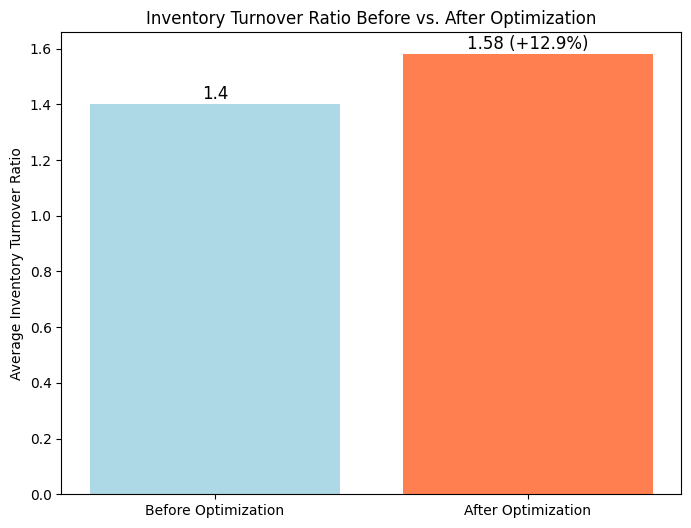

In [12]:
import matplotlib.pyplot as plt

# Define turnover ratios before and after optimization
before_optimization = 1.4
after_optimization = 1.58

# Calculate percentage increase
percentage_increase = ((after_optimization - before_optimization) / before_optimization) * 100

# Plotting the bar chart
plt.figure(figsize=(8, 6))
plt.bar(['Before Optimization', 'After Optimization'], [before_optimization, after_optimization], color=['lightblue', 'coral'])

# Adding labels and title
plt.title('Inventory Turnover Ratio Before vs. After Optimization')
plt.ylabel('Average Inventory Turnover Ratio')
plt.text(0, before_optimization + 0.02, f'{before_optimization}', ha='center', fontsize=12)
plt.text(1, after_optimization + 0.02, f'{after_optimization} (+{percentage_increase:.1f}%)', ha='center', fontsize=12)

# Display the plot
plt.show()



The increase in the average inventory turnover from 1.40 to 1.58, a 12.9% improvement, demonstrates that our demand forecasting model and inventory optimization strategy have moved our turnover ratio closer to a healthy range typically seen in successful e-commerce operations, generally between 1.5 and 2. This improvement means that inventory is now moving at a rate that better matches actual demand, reducing excess stock and associated holding costs. By achieving a higher turnover ratio, our model helps maintain leaner inventory levels, ensuring that stock is available when needed without overstocking, which ultimately supports a more responsive and cost-effective inventory system.